In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt

#Currencies
peso_dollar = pdr.get_data_fred("DEXMXUS", "1975-01-01", "2019-12-31")
peso_dollar = peso_dollar.squeeze()
HK_dollar = pdr.get_data_fred("DEXUSEU", "1975-01-01", "2019-12-31")
dollar_pound = pdr.get_data_fred("DEXUSUK", "1975-01-01", "2019-12-31")
dollar_pound = dollar_pound.squeeze()

#Create / currency
HK_GBP = HK_dollar
HK_GBP["DEXHKUK"] = dollar_pound / HK_dollar["DEXUSEU"] 
HK_GBP = HK_GBP.drop(columns=["DEXUSEU"])
HK_GBP = HK_GBP.squeeze()


#indexes
KS11 = pdr.get_data_yahoo('^KS11', start='1997-07-01', end='2019-12-31')
KS11 = KS11.drop(columns=["High", "Low", "Open", "Volume", "Close"])
KS11 = KS11.squeeze()
BVSP = pdr.get_data_yahoo('^BVSP', start='1993-04-23', end='2019-12-31')
BVSP = BVSP.drop(columns=["High", "Low", "Open", "Volume", "Close"])
BVSP = BVSP.squeeze()
DAX = pdr.get_data_yahoo('^GDAXI', start='1987-12-30', end='2019-12-31')
DAX = DAX.drop(columns=["High", "Low", "Open", "Volume", "Close"])
DAX = DAX.squeeze()
VBTLX = pdr.get_data_yahoo('VBTLX', start='2001-11-12', end='2019-12-31')
VBTLX = VBTLX.drop(columns=["High", "Low", "Open", "Volume", "Close"])
VBTLX = VBTLX.squeeze()

#Factors
ff_factors = pdr.get_data_famafrench("F-F_Research_Data_Factors_daily", start="1920", end="2019-12-31")[0]
ff_factors_mom = pdr.get_data_famafrench("F-F_Momentum_Factor_daily", start="1920", end="2019-12-31")[0]
# ff_factors = ff_factors.join(ff_factors_mom).dropna()
ff_factors = pd.concat([ff_factors,ff_factors_mom], axis=1)
ff_factors = ff_factors.dropna()
ff_factors.columns = [col.strip(' ') for col in ff_factors.columns]
ff_factors_price = (1+(ff_factors/100)).cumprod()

In [2]:
import numpy as np
import pandas as pd

def summary_statistics(prices):

    d_returns = prices.pct_change().dropna()
    w_returns = prices.resample("W-FRI").last().pct_change().dropna()
    m_returns = prices.resample("M").last().pct_change().dropna()
    q_returns = prices.resample("Q").last().pct_change().dropna()
    y_returns = prices.resample("A").last().pct_change().dropna()
    # Convert prices to returns

    # Enclosed function to find mean, std, skew and kurt: gives annualised stats
    def process(returns, n):
        returns_mu = returns.mean()                         # mean returns per time period
        annual_mu =  returns_mu * n                          # annualised mean returns

        returns_err = returns - returns_mu       
        returns_var = (returns_err ** 2).mean()             # average squared return ( 2nd moment)
        annual_var = returns_var * n                        # annual rescaled variance
        annual_std = np.sqrt(annual_var)                    # annual rescaled std deviation

        returns_mom3 = (returns_err ** 3).mean()
        returns_mom4 = (returns_err ** 4).mean()            # Third and Fourth moments


        annual_skew = (returns_mom3 / returns_var ** (3/2)) #/ np.sqrt(n)  # rescaled Skew and Kurtosis
        annual_kurt = (returns_mom4 / returns_var ** (4/2)) #/ n

        returns_stats = pd.Series([annual_mu, annual_std, annual_skew, annual_kurt], index = ["mean", "std", "skew", "kurt"])
        
        return returns_stats
         
    # Feed in daily, weekly, monthly and quarterly data
    d_stats = process(d_returns, n = 252).rename("Daily")
    w_stats = process(w_returns, n = 52 ).rename("Weekly")
    m_stats = process(m_returns, n = 12 ).rename("Monthly")
    q_stats = process(q_returns, n = 4  ).rename("Quarterly")
    y_stats = process(y_returns, n = 1  ).rename("Annual")

    # Concatenate the series into a dataframe
    stats = pd.concat([d_stats, w_stats, m_stats, q_stats, y_stats], axis=1)

    return stats

In [3]:
a = round(summary_statistics(HK_GBP),3)
print(summary_statistics(HK_GBP).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     Daily &    Weekly &   Monthly &  Quarterly &    Annual \\
\midrule
mean & -0.004727 & -0.005385 & -0.006590 &  -0.008229 & -0.012186 \\
std  &  0.079820 &  0.081592 &  0.077987 &   0.076762 &  0.073662 \\
skew & -0.363522 &  0.170465 & -0.930827 &  -0.809916 & -1.310201 \\
kurt &  8.735029 &  7.325696 &  7.507785 &   6.175097 &  4.427539 \\
\bottomrule
\end{tabular}



In [4]:
b = round(summary_statistics(peso_dollar),3)
b

,Daily,Weekly,Monthly,Quarterly,Annual
mean,0.076,0.076,0.079,0.081,0.083
std,0.145,0.135,0.144,0.157,0.171
skew,5.119,6.175,4.546,2.987,1.803
kurt,148.950,106.744,45.524,15.473,5.739


In [5]:
e = np.round(summary_statistics(KS11),3)
e

,Daily,Weekly,Monthly,Quarterly,Annual
mean,0.085,0.082,0.086,0.104,0.128
std,0.272,0.270,0.276,0.323,0.305
skew,-0.025,-0.144,0.846,1.198,0.105
kurt,8.886,8.045,8.442,9.032,3.031


In [6]:
f = np.round(summary_statistics(VBTLX),3)
f

,Daily,Weekly,Monthly,Quarterly,Annual
mean,0.038,0.039,0.039,0.040,0.040
std,0.039,0.037,0.034,0.033,0.027
skew,0.076,-0.396,-0.205,-0.147,-0.396
kurt,4.365,4.097,4.433,2.570,2.697


In [7]:
c = np.round(summary_statistics(DAX),3)
c

,Daily,Weekly,Monthly,Quarterly,Annual
mean,0.105,0.103,0.102,0.108,0.112
std,0.220,0.212,0.203,0.226,0.230
skew,-0.082,-0.351,-0.518,-0.631,-0.653
kurt,8.793,6.865,5.062,4.658,2.785


In [8]:
d = np.round(summary_statistics(BVSP),3)
d

,Daily,Weekly,Monthly,Quarterly,Annual
mean,0.386,0.378,0.404,0.475,0.607
std,0.355,0.352,0.437,0.828,2.042
skew,0.950,0.632,2.288,4.475,4.481
kurt,17.757,7.500,15.097,27.744,22.036


In [9]:
g = np.round(summary_statistics(ff_factors_price["Mom"]),3)
g

,Daily,Weekly,Monthly,Quarterly,Annual
mean,0.067,0.072,0.075,0.075,0.077
std,0.118,0.137,0.152,0.151,0.154
skew,-1.595,-1.390,-0.915,-0.994,-0.722
kurt,29.865,15.511,11.375,9.299,5.382


In [10]:
i = np.round(summary_statistics(ff_factors_price["SMB"]),3)

In [11]:
h = np.round(summary_statistics(ff_factors_price["HML"]),3)

In [12]:
j = np.round(summary_statistics(ff_factors_price["Mkt-RF"]),3)

In [13]:
table_d = pd.concat([a["Daily"],b["Daily"],c["Daily"],d["Daily"],e["Daily"],f["Daily"],g["Daily"],h["Daily"],i["Daily"],j["Daily"]],axis=1)
table_d.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Mom", "Value", "Size", "Market"]
table_d = np.round(table_d,3)
table_d.name = "Daily"
print(table_d.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &    BSVP &   KS11 &  VBTLX &     Mom &   Value &    Size &  Market \\
\midrule
mean &  -0.005 &    0.076 &  0.105 &   0.386 &  0.085 &  0.038 &   0.067 &   0.039 &   0.012 &   0.074 \\
std  &   0.080 &    0.145 &  0.220 &   0.355 &  0.272 &  0.039 &   0.118 &   0.093 &   0.093 &   0.169 \\
skew &  -0.364 &    5.119 & -0.082 &   0.950 & -0.025 &  0.076 &  -1.595 &   0.732 &  -0.755 &  -0.121 \\
kurt &   8.735 &  148.950 &  8.793 &  17.757 &  8.886 &  4.365 &  29.865 &  18.748 &  25.650 &  19.601 \\
\bottomrule
\end{tabular}



In [14]:
table_w = pd.concat([a["Weekly"],b["Weekly"],c["Weekly"],d["Weekly"],e["Weekly"],f["Weekly"],g["Weekly"],h["Weekly"],i["Weekly"],j["Weekly"]],axis=1)
table_w.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Mom", "Value", "Size", "Market"]
table_w = np.round(table_w,3)
table_w.name = "Weekly"
print(table_w.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &   BSVP &   KS11 &  VBTLX &     Mom &   Value &    Size &  Market \\
\midrule
mean &  -0.005 &    0.076 &  0.103 &  0.378 &  0.082 &  0.039 &   0.072 &   0.041 &   0.012 &   0.077 \\
std  &   0.082 &    0.135 &  0.212 &  0.352 &  0.270 &  0.037 &   0.137 &   0.102 &   0.091 &   0.172 \\
skew &   0.170 &    6.175 & -0.351 &  0.632 & -0.144 & -0.396 &  -1.390 &   1.102 &   0.083 &  -0.358 \\
kurt &   7.326 &  106.744 &  6.865 &  7.500 &  8.045 &  4.097 &  15.511 &  16.147 &  13.124 &   9.143 \\
\bottomrule
\end{tabular}



In [15]:
table_m = pd.concat([a["Monthly"],b["Monthly"],c["Monthly"],d["Monthly"],e["Monthly"],f["Monthly"],g["Monthly"],h["Monthly"],i["Monthly"],j["Monthly"]],axis=1)
table_m.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Mom", "Value", "Size", "Market"]
table_m = np.round(table_m,3)
print(table_m.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &    BSVP &   KS11 &  VBTLX &     Mom &   Value &    Size &  Market \\
\midrule
mean &  -0.007 &    0.079 &  0.102 &   0.404 &  0.086 &  0.039 &   0.075 &   0.043 &   0.013 &   0.080 \\
std  &   0.078 &    0.144 &  0.203 &   0.437 &  0.276 &  0.034 &   0.152 &   0.115 &   0.107 &   0.185 \\
skew &  -0.931 &    4.546 & -0.518 &   2.288 &  0.846 & -0.205 &  -0.915 &   1.292 &   1.117 &   0.193 \\
kurt &   7.508 &   45.524 &  5.062 &  15.097 &  8.442 &  4.433 &  11.375 &  12.344 &  13.602 &  10.933 \\
\bottomrule
\end{tabular}



In [16]:
table_q = pd.concat([a["Quarterly"],b["Quarterly"],c["Quarterly"],d["Quarterly"],e["Quarterly"],f["Quarterly"],g["Quarterly"],h["Quarterly"],i["Quarterly"],j["Quarterly"]],axis=1)
table_q.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Mom", "Value", "Size", "Market"]
table_q = np.round(table_q,3)
print(table_q.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &    BSVP &   KS11 &  VBTLX &    Mom &   Value &    Size &  Market \\
\midrule
mean &  -0.008 &    0.081 &  0.108 &   0.475 &  0.104 &  0.040 &  0.075 &   0.045 &   0.014 &   0.085 \\
std  &   0.077 &    0.157 &  0.226 &   0.828 &  0.323 &  0.033 &  0.151 &   0.135 &   0.116 &   0.220 \\
skew &  -0.810 &    2.987 & -0.631 &   4.475 &  1.198 & -0.147 & -0.994 &   1.336 &   1.216 &   1.822 \\
kurt &   6.175 &   15.473 &  4.658 &  27.744 &  9.032 &  2.570 &  9.299 &  11.969 &  10.225 &  19.834 \\
\bottomrule
\end{tabular}



In [17]:
table_a = pd.concat([a["Annual"],b["Annual"],c["Annual"],d["Annual"],e["Annual"],f["Annual"],g["Annual"],h["Annual"],i["Annual"],j["Annual"]],axis=1)
table_a.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Mom", "Value", "Size", "Market"]
table_a = np.round(table_a,3)
print(table_a.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &    BSVP &   KS11 &  VBTLX &    Mom &  Value &   Size &  Market \\
\midrule
mean &  -0.012 &    0.083 &  0.112 &   0.607 &  0.128 &  0.040 &  0.077 &  0.045 &  0.014 &   0.084 \\
std  &   0.074 &    0.171 &  0.230 &   2.042 &  0.305 &  0.027 &  0.154 &  0.130 &  0.117 &   0.197 \\
skew &  -1.310 &    1.803 & -0.653 &   4.481 &  0.105 & -0.396 & -0.722 &  0.353 &  0.226 &  -0.298 \\
kurt &   4.428 &    5.739 &  2.785 &  22.036 &  3.031 &  2.697 &  5.382 &  3.470 &  4.180 &   2.982 \\
\bottomrule
\end{tabular}



In [18]:
KS11_2019 = summary_statistics(KS11["31/12/2009":"31/12/2019"])
KS11_2019 = KS11_2019.drop(columns="Annual")
KS11_2019 = np.round(KS11_2019,3)
KS11_2009 = summary_statistics(KS11["31/12/1999":"31/12/2009"])
KS11_2009 = KS11_2009.drop(columns="Annual")
KS11_2009 = np.round(KS11_2009,3)
KS11_1999 = summary_statistics(KS11["31/12/1989":"31/12/1999"])
KS11_1999 = KS11_1999.drop(columns="Annual")
KS11_1999 = np.round(KS11_1999,3)
KS11_1989 = summary_statistics(KS11["31/12/1979":"31/12/1989"])
KS11_1989 = KS11_1989.drop(columns="Annual")
KS11_1989 = np.round(KS11_1989,3)

In [19]:
BSVP = np.round(BVSP,3)
BSVP_2019 = summary_statistics(BSVP["31/12/2009":"31/12/2019"])
BSVP_2019 = BSVP_2019.drop(columns="Annual")
BSVP_2019 = np.round(BSVP_2019,3)
BSVP_2009 = summary_statistics(BSVP["31/12/1999":"31/12/2009"])
BSVP_2009 = BSVP_2009.drop(columns="Annual")
BSVP_2009 = np.round(BSVP_2009,3)
BSVP_1999 = summary_statistics(BSVP["31/12/1989":"31/12/1999"])
BSVP_1999 = BSVP_1999.drop(columns="Annual")
BSVP_1999 = np.round(BSVP_1999,3)
BSVP_1989 = summary_statistics(BSVP["31/12/1979":"31/12/1989"])
BSVP_1989 = BSVP_1989.drop(columns="Annual")
BSVP_1989 = np.round(BSVP_1989,3)
BSVP_1999

,Daily,Weekly,Monthly,Quarterly
mean,1.133,1.120,1.241,1.538
std,0.520,0.517,0.716,1.490
skew,0.986,0.417,1.164,2.056
kurt,13.305,4.508,5.941,7.076


In [20]:
DAX = np.round(DAX,3)
DAX_2019 = summary_statistics(DAX["31/12/2009":"31/12/2019"])
DAX_2019 = DAX_2019.drop(columns="Annual")
DAX_2009 = summary_statistics(DAX["31/12/1999":"31/12/2009"])
DAX_2009 = DAX_2009.drop(columns="Annual")
DAX_1999 = summary_statistics(DAX["31/12/1989":"31/12/1999"])
DAX_1999 = DAX_1999.drop(columns="Annual")
DAX_1989 = summary_statistics(DAX["31/12/1979":"31/12/1989"])
DAX_1989 = DAX_1989.drop(columns="Annual")

In [21]:
VBTLX = np.round(VBTLX,3)
VBTLX_2019 = summary_statistics(VBTLX["31/12/2009":"31/12/2019"])
VBTLX_2019 = VBTLX_2019.drop(columns="Annual")
VBTLX_2009 = summary_statistics(VBTLX["31/12/1999":"31/12/2009"])
VBTLX_2009 = VBTLX_2009.drop(columns="Annual")
VBTLX_1999 = summary_statistics(VBTLX["31/12/1989":"31/12/1999"])
VBTLX_1999 = VBTLX_1999.drop(columns="Annual")
VBTLX_1989 = summary_statistics(VBTLX["31/12/1979":"31/12/1989"])
VBTLX_1989 = VBTLX_1989.drop(columns="Annual")
VBTLX

Date
2001-11-12     5.528
2001-11-13     5.518
2001-11-14     5.491
2001-11-15     5.444
2001-11-16     5.412
               ...  
2019-12-24    10.815
2019-12-26    10.825
2019-12-27    10.835
2019-12-30    10.835
2019-12-31    10.840
Name: Adj Close, Length: 4565, dtype: float64

In [22]:
HK_GBP = np.round(HK_GBP,3)
HK_GBP_2019 = summary_statistics(HK_GBP["31/12/2009":"31/12/2019"])
HK_GBP_2019 = HK_GBP_2019.drop(columns="Annual")
HK_GBP_2009 = summary_statistics(HK_GBP["31/12/1999":"31/12/2009"])
HK_GBP_2009 = HK_GBP_2009.drop(columns="Annual")
HK_GBP_1999 = summary_statistics(HK_GBP["31/12/1989":"31/12/1999"])
HK_GBP_1999 = HK_GBP_1999.drop(columns="Annual")
HK_GBP_1989 = summary_statistics(HK_GBP["31/12/1979":"31/12/1989"])
HK_GBP_1989 = HK_GBP_1989.drop(columns="Annual")

In [23]:
peso_dollar = np.round(peso_dollar,3)
peso_dollar_2019 = summary_statistics(peso_dollar["31/12/2009":"31/12/2019"])
peso_dollar_2019 = peso_dollar_2019.drop(columns="Annual")
peso_dollar_2009 = summary_statistics(peso_dollar["31/12/1999":"31/12/2009"])
peso_dollar_2009 = peso_dollar_2009.drop(columns="Annual")
peso_dollar_1999 = summary_statistics(peso_dollar["31/12/1989":"31/12/1999"])
peso_dollar_1999 = peso_dollar_1999.drop(columns="Annual")
peso_dollar_1989 = summary_statistics(peso_dollar["31/12/1979":"31/12/1989"])
peso_dollar_1989 = peso_dollar_1989.drop(columns="Annual")

In [24]:
mom = np.round(ff_factors_price["Mom"],3)
mom = np.round(mom,3)
mom_2019 = summary_statistics(mom["31/12/2009":"31/12/2019"])
mom_2019 = mom_2019.drop(columns="Annual")
mom_2009 = summary_statistics(mom["31/12/1999":"31/12/2009"])
mom_2009 = mom_2009.drop(columns="Annual")
mom_1999 = summary_statistics(mom["31/12/1989":"31/12/1999"])
mom_1999 = mom_1999.drop(columns="Annual")
mom_1989 = summary_statistics(mom["31/12/1979":"31/12/1989"])
mom_1989 = mom_1989.drop(columns="Annual")

In [25]:
market = np.round(ff_factors_price["Mkt-RF"],3)
market = np.round(market,3)
market_2019 = summary_statistics(market["31/12/2009":"31/12/2019"])
market_2019 = market_2019.drop(columns="Annual")
market_2009 = summary_statistics(market["31/12/1999":"31/12/2009"])
market_2009 = market_2009.drop(columns="Annual")
market_1999 = summary_statistics(market["31/12/1989":"31/12/1999"])
market_1999 = market_1999.drop(columns="Annual")
market_1989 = summary_statistics(market["31/12/1979":"31/12/1989"])
market_1989 = market_1989.drop(columns="Annual")

In [26]:
size = np.round(ff_factors_price["SMB"],3)
size = np.round(size,3)
size_2019 = summary_statistics(size["31/12/2009":"31/12/2019"])
size_2019 = size_2019.drop(columns="Annual")
size_2009 = summary_statistics(size["31/12/1999":"31/12/2009"])
size_2009 = size_2009.drop(columns="Annual")
size_1999 = summary_statistics(size["31/12/1989":"31/12/1999"])
size_1999 = size_1999.drop(columns="Annual")
size_1989 = summary_statistics(size["31/12/1979":"31/12/1989"])
size_1989 = size_1989.drop(columns="Annual")

In [27]:
value = np.round(ff_factors_price["HML"],3)
value = np.round(value,3)
value_2019 = summary_statistics(value["31/12/2009":"31/12/2019"])
value_2019 = value_2019.drop(columns="Annual")
value_2009 = summary_statistics(value["31/12/1999":"31/12/2009"])
value_2009 = value_2009.drop(columns="Annual")
value_1999 = summary_statistics(value["31/12/1989":"31/12/1999"])
value_1999 = value_1999.drop(columns="Annual")
value_1989 = summary_statistics(value["31/12/1979":"31/12/1989"])
value_1989 = value_1989.drop(columns="Annual")

In [28]:
# Daily 2019
sub_table1d = pd.concat([HK_GBP_2019["Daily"],peso_dollar_2019["Daily"],DAX_2019["Daily"], BSVP_2019["Daily"], KS11_2019["Daily"], VBTLX_2019["Daily"], mom_2019["Daily"], value_2019["Daily"], size_2019["Daily"],market_2019["Daily"]], axis=1)
sub_table1d = np.round(sub_table1d,3)
sub_table1d.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Momentum", "Value", "Size", "Market"]
sub_table1d

,HK/GBP,MXN/USD,DAX,BSVP,KS11,VBTLX,Momentum,Value,Size,Market
mean,0.008,0.042,0.096,0.076,0.038,0.037,0.048,-0.024,-0.003,0.134
std,0.081,0.110,0.189,0.223,0.148,0.035,0.112,0.080,0.082,0.152
skew,-0.530,0.758,-0.229,-0.068,-0.375,-0.100,-0.314,0.343,0.170,-0.422
kurt,10.189,9.937,5.669,4.787,6.891,3.872,5.034,4.926,4.498,7.373


In [29]:
# Weekly 2019
sub_table1w = pd.concat([HK_GBP_2019["Weekly"],peso_dollar_2019["Weekly"],DAX_2019["Weekly"], BSVP_2019["Weekly"], KS11_2019["Weekly"], VBTLX_2019["Weekly"], mom_2019["Weekly"], value_2019["Weekly"], size_2019["Weekly"],market_2019["Weekly"]], axis=1)
sub_table1w = np.round(sub_table1w,3)
sub_table1w.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Momentum", "Value", "Size", "Market"]
sub_table1w

,HK/GBP,MXN/USD,DAX,BSVP,KS11,VBTLX,Momentum,Value,Size,Market
mean,0.008,0.043,0.096,0.072,0.036,0.036,0.047,-0.023,-0.003,0.132
std,0.077,0.110,0.185,0.210,0.142,0.034,0.110,0.080,0.080,0.144
skew,0.043,0.441,-0.411,0.294,-0.628,-0.581,-0.631,0.486,0.186,-0.513
kurt,3.561,4.588,4.853,5.435,5.081,4.269,4.865,4.570,4.533,4.886


In [30]:
# Monthly 2019
sub_table1m = pd.concat([HK_GBP_2019["Monthly"],peso_dollar_2019["Monthly"],DAX_2019["Monthly"], BSVP_2019["Monthly"], KS11_2019["Monthly"], VBTLX_2019["Monthly"], mom_2019["Monthly"], value_2019["Monthly"], size_2019["Monthly"],market_2019["Monthly"]], axis=1)
sub_table1m = np.round(sub_table1m,3)
sub_table1m.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Momentum", "Value", "Size", "Market"]
sub_table1m

,HK/GBP,MXN/USD,DAX,BSVP,KS11,VBTLX,Momentum,Value,Size,Market
mean,0.007,0.043,0.100,0.077,0.040,0.036,0.048,-0.024,-0.003,0.131
std,0.074,0.116,0.160,0.196,0.130,0.030,0.112,0.078,0.077,0.129
skew,-0.455,0.698,-0.528,0.212,-0.545,-0.071,0.044,0.678,0.094,-0.370
kurt,4.181,3.821,4.992,2.887,4.341,3.740,3.632,3.863,2.645,3.514


In [31]:
# Quarterly 2019
sub_table1q = pd.concat([HK_GBP_2019["Quarterly"],peso_dollar_2019["Quarterly"],DAX_2019["Quarterly"], BSVP_2019["Quarterly"], KS11_2019["Quarterly"], VBTLX_2019["Quarterly"], mom_2019["Quarterly"], value_2019["Quarterly"], size_2019["Quarterly"],market_2019["Quarterly"]], axis=1)
sub_table1q = np.round(sub_table1q,3)
sub_table1q.columns = ["HK/GBP", "MXN/USD", "DAX", "BVSP", "KS11", "VBTLX", "Momentum", "Value", "Size", "Market"]
print(sub_table1q.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &   BVSP &   KS11 &  VBTLX &  Momentum &  Value &   Size &  Market \\
\midrule
mean &   0.007 &    0.043 &  0.095 &  0.070 &  0.034 &  0.037 &     0.045 & -0.023 & -0.004 &   0.133 \\
std  &   0.065 &    0.108 &  0.175 &  0.192 &  0.117 &  0.032 &     0.085 &  0.084 &  0.073 &   0.133 \\
skew &   0.266 &    0.494 & -0.659 & -0.459 & -0.588 & -0.431 &    -0.172 &  1.424 & -0.396 &  -1.072 \\
kurt &   3.093 &    3.470 &  4.358 &  2.223 &  3.652 &  2.937 &     3.786 &  7.291 &  2.998 &   4.298 \\
\bottomrule
\end{tabular}



In [32]:
# Quarterly 2009
sub_table2q = pd.concat([HK_GBP_2009["Quarterly"],peso_dollar_2009["Quarterly"],DAX_2009["Quarterly"], BSVP_2009["Quarterly"], KS11_2009["Quarterly"], VBTLX_2009["Quarterly"], mom_2009["Quarterly"], value_2009["Quarterly"], size_2009["Quarterly"],market_2009["Quarterly"]], axis=1)
sub_table2q = np.round(sub_table2q,3)
sub_table2q.columns = ["HK/GBP", "MXN/USD", "DAX", "BVSP", "KS11", "VBTLX", "Momentum", "Value", "Size", "Market"]
print(sub_table2q.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &   BVSP &   KS11 &  VBTLX &  Momentum &  Value &   Size &  Market \\
\midrule
mean &  -0.031 &    0.037 &  0.016 &  0.188 &  0.113 &  0.044 &     0.027 &  0.091 &  0.040 &  -0.014 \\
std  &   0.087 &    0.108 &  0.278 &  0.311 &  0.300 &  0.034 &     0.223 &  0.153 &  0.097 &   0.184 \\
skew &  -1.037 &    2.543 & -0.366 & -0.046 &  0.314 &  0.111 &    -0.470 &  1.039 &  0.201 &  -0.275 \\
kurt &   6.075 &   12.495 &  3.409 &  2.629 &  3.079 &  2.094 &     4.183 &  4.914 &  2.535 &   2.724 \\
\bottomrule
\end{tabular}



In [33]:
# Quarterly 1999
sub_table3q = pd.concat([HK_GBP_1999["Quarterly"],peso_dollar_1999["Quarterly"],DAX_1999["Quarterly"], BSVP_1999["Quarterly"], KS11_1999["Quarterly"], VBTLX_1999["Quarterly"], mom_1999["Quarterly"], value_1999["Quarterly"], size_1999["Quarterly"],market_1999["Quarterly"]], axis=1)
sub_table3q = np.round(sub_table3q,3)
sub_table3q.columns = ["HK/GBP", "MXN/USD", "DAX", "BVSP", "KS11", "VBTLX", "Momentum", "Value", "Size", "Market"]
print(sub_table3q.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &   BVSP &   KS11 &  VBTLX &  Momentum &  Value &   Size &  Market \\
\midrule
mean &   0.097 &    0.216 &  0.159 &  1.538 &  0.462 &    NaN &     0.143 &  0.007 & -0.022 &   0.138 \\
std  &   0.022 &    0.250 &  0.230 &  1.490 &  0.727 &    NaN &     0.129 &  0.117 &  0.111 &   0.146 \\
skew &   0.019 &    2.143 & -0.486 &  2.056 &  0.217 &    NaN &     0.760 &  0.299 &  0.111 &  -0.212 \\
kurt &   1.500 &    6.950 &  4.759 &  7.076 &  2.477 &    NaN &     4.011 &  4.041 &  2.565 &   4.136 \\
\bottomrule
\end{tabular}



In [34]:
# Quarterly 1989
sub_table4q = pd.concat([HK_GBP_1989["Quarterly"],peso_dollar_1989["Quarterly"],DAX_1989["Quarterly"], BSVP_1989["Quarterly"], KS11_1989["Quarterly"], VBTLX_1989["Quarterly"], mom_1989["Quarterly"], value_1989["Quarterly"], size_1989["Quarterly"],market_1989["Quarterly"]], axis=1)
sub_table4q = np.round(sub_table4q,3)
sub_table4q.columns = ["HK/GBP", "MXN/USD", "DAX", "BVSP", "KS11", "VBTLX", "Momentum", "Value", "Size", "Market"]
print(sub_table4q.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &  BVSP &  KS11 &  VBTLX &  Momentum &  Value &   Size &  Market \\
\midrule
mean &     NaN &      NaN &  0.299 &   NaN &   NaN &    NaN &     0.086 &  0.067 & -0.012 &   0.087 \\
std  &     NaN &      NaN &  0.083 &   NaN &   NaN &    NaN &     0.108 &  0.113 &  0.089 &   0.176 \\
skew &     NaN &      NaN & -0.465 &   NaN &   NaN &    NaN &    -0.056 &  0.200 &  0.270 &  -0.559 \\
kurt &     NaN &      NaN &  2.637 &   NaN &   NaN &    NaN &     2.653 &  3.199 &  2.727 &   3.530 \\
\bottomrule
\end{tabular}



In [35]:
from matplotlib import pyplot

(-0.1, 0.5)

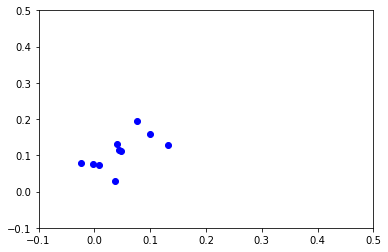

In [36]:


ax = plt.gca()

ax.scatter([HK_GBP_2019["Monthly"]["mean"]], [HK_GBP_2019["Monthly"]["std"]], color="b")
ax.scatter([peso_dollar_2019["Monthly"]["mean"]], [peso_dollar_2019["Monthly"]["std"]], color="b")
ax.scatter([DAX_2019["Monthly"]["mean"]], [DAX_2019["Monthly"]["std"]], color="b")
ax.scatter([BSVP_2019["Monthly"]["mean"]], [BSVP_2019["Monthly"]["std"]], color="b")
ax.scatter([KS11_2019["Monthly"]["mean"]], [KS11_2019["Monthly"]["std"]], color="b")
ax.scatter([VBTLX_2019["Monthly"]["mean"]], [VBTLX_2019["Monthly"]["std"]], color="b")
ax.scatter([mom_2019["Monthly"]["mean"]], [mom_2019["Monthly"]["std"]], color="b")
ax.scatter([value_2019["Monthly"]["mean"]], [value_2019["Monthly"]["std"]], color="b")
ax.scatter([size_2019["Monthly"]["mean"]], [size_2019["Monthly"]["std"]], color="b")
ax.scatter([market_2019["Monthly"]["mean"]], [market_2019["Monthly"]["std"]], color="b")

x_2019 = np.array([HK_GBP_2019["Monthly"]["mean"],peso_dollar_2019["Monthly"]["mean"],DAX_2019["Monthly"]["mean"],BSVP_2019["Monthly"]["mean"],KS11_2019["Monthly"]["mean"],VBTLX_2019["Monthly"]["mean"],mom_2019["Monthly"]["mean"],value_2019["Monthly"]["mean"],size_2019["Monthly"]["mean"],market_2019["Monthly"]["mean"]])

plt.xlim(-0.1, 0.5)
plt.ylim(-0.1, 0.50)

In [37]:
a["Monthly"]["std"]

0.078

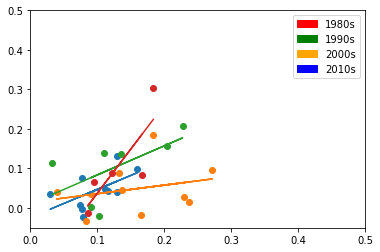

In [39]:
y_2019 = np.array([HK_GBP_2019["Monthly"]["mean"],peso_dollar_2019["Monthly"]["mean"],DAX_2019["Monthly"]["mean"],BSVP_2019["Monthly"]["mean"],KS11_2019["Monthly"]["mean"],VBTLX_2019["Monthly"]["mean"],mom_2019["Monthly"]["mean"],value_2019["Monthly"]["mean"],size_2019["Monthly"]["mean"],market_2019["Monthly"]["mean"]])

x_2019 = np.array([HK_GBP_2019["Monthly"]["std"],peso_dollar_2019["Monthly"]["std"],DAX_2019["Monthly"]["std"],BSVP_2019["Monthly"]["mean"],KS11_2019["Monthly"]["std"],VBTLX_2019["Monthly"]["std"],mom_2019["Monthly"]["std"],value_2019["Monthly"]["std"],size_2019["Monthly"]["std"],market_2019["Monthly"]["std"]])

y_2009 = np.array([HK_GBP_2009["Monthly"]["mean"],peso_dollar_2009["Monthly"]["mean"],DAX_2009["Monthly"]["mean"],BSVP_2009["Monthly"]["mean"],KS11_2009["Monthly"]["mean"],VBTLX_2009["Monthly"]["mean"],mom_2009["Monthly"]["mean"],value_2009["Monthly"]["mean"],size_2009["Monthly"]["mean"],market_2009["Monthly"]["mean"]])

x_2009 = np.array([HK_GBP_2009["Monthly"]["std"],peso_dollar_2009["Monthly"]["std"],DAX_2009["Monthly"]["std"],BSVP_2009["Monthly"]["mean"],KS11_2009["Monthly"]["std"],VBTLX_2009["Monthly"]["std"],mom_2009["Monthly"]["std"],value_2009["Monthly"]["std"],size_2009["Monthly"]["std"],market_2009["Monthly"]["std"]])

y_1999 = np.array([HK_GBP_1999["Monthly"]["mean"],peso_dollar_1999["Monthly"]["mean"],DAX_1999["Monthly"]["mean"],mom_1999["Monthly"]["mean"],value_1999["Monthly"]["mean"],size_1999["Monthly"]["mean"],market_1999["Monthly"]["mean"]])

x_1999 = np.array([HK_GBP_1999["Monthly"]["std"],peso_dollar_1999["Monthly"]["std"],DAX_1999["Monthly"]["std"],mom_1999["Monthly"]["std"],value_1999["Monthly"]["std"],size_1999["Monthly"]["std"],market_1999["Monthly"]["std"]])

y_1989 = np.array([DAX_1989["Monthly"]["mean"],mom_1989["Monthly"]["mean"],value_1989["Monthly"]["mean"],size_1989["Monthly"]["mean"],market_1989["Monthly"]["mean"]])

x_1989 = np.array([DAX_1989["Monthly"]["std"],mom_1989["Monthly"]["std"],value_1989["Monthly"]["std"],size_1989["Monthly"]["std"],market_1989["Monthly"]["std"]])


ax1 = plt.gca()

ax1.scatter([x_2019],[y_2019] )
ax1.scatter([x_2009],[y_2009])
ax1.scatter([x_1999],[y_1999])
ax1.scatter([x_1989],[y_1989])

plt.xlim(-0, .5)
plt.ylim(-0.05, .5)


m_2019, b_2019 = np.polyfit(x_2019, y_2019, 1)
plt.plot(x_2019, m_2019*x_2019 + b_2019)

m_2009, b_2009 = np.polyfit(x_2009, y_2009, 1)
plt.plot(x_2009, m_2009*x_2009 + b_2009)

m_1999, b_1999 = np.polyfit(x_1999, y_1999, 1)
plt.plot(x_1999, m_1999*x_1999 + b_1999)

m_1989, b_1989 = np.polyfit(x_1989, y_1989, 1)
plt.plot(x_1989, m_1989*x_1989 + b_1989)

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='1980s')
green_patch = mpatches.Patch(color='green', label='1990s')
orange_patch = mpatches.Patch(color='orange', label='2000s')
blue_patch = mpatches.Patch(color='blue', label='2010s')
plt.legend(handles=[red_patch, green_patch,orange_patch,blue_patch])

graph_1 = ax1


In [39]:
y_1989

array([ 0.00839661,  0.30485535,  0.0875166 ,  0.06528208, -0.0120143 ,
        0.08464841])

In [40]:
print(KS11_2019.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Daily &  Weekly &  Monthly &  Quarterly \\
\midrule
mean &  0.038 &   0.036 &    0.040 &      0.034 \\
std  &  0.148 &   0.142 &    0.130 &      0.117 \\
skew & -0.375 &  -0.628 &   -0.545 &     -0.588 \\
kurt &  6.891 &   5.081 &    4.341 &      3.652 \\
\bottomrule
\end{tabular}



In [41]:
from scipy.special import gammaln
from scipy.optimize import minimize

def students_dof(prices):
    def std_t_loglik(nu, x):
        # These are fixed for now
        mu = 0
        sigma2 = 1
        sigma = np.sqrt(sigma2)

        a = gammaln((nu + 1) / 2)
        b = gammaln(nu / 2)
        c = np.sqrt(np.pi * (nu-2))
        d = ((nu + 1) / 2)
        e = (x - mu) **2
        f = sigma2 * (nu - 2)

        loglik = a - b - np.log(c) - np.log(sigma) - d * np.log(1 + e / f)
        return -(loglik.sum())
    
    d_returns = prices.pct_change().dropna()
    w_returns = prices.resample("W-FRI").last().pct_change().dropna()
    m_returns = prices.resample("M").last().pct_change().dropna()
    q_returns = prices.resample("Q").last().pct_change().dropna()

    std_d = (d_returns - d_returns.mean())/ d_returns.std()

    starting_val = np.array([10]) 
    opt = minimize(std_t_loglik, starting_val, args=(std_d), bounds=[(2.01, 100)], options={"disp": True})
    mle = opt.x[0]   
    return mle

In [42]:
def dof(prices):
    def full_std_t_loglik(parameters, x):
        # These are fixed for now
        mu = parameters[0]
        sigma2 = parameters[1]
        nu = parameters[2]
        sigma = np.sqrt(sigma2)
   
        a = gammaln((nu + 1) / 2)
        b = gammaln(nu / 2)
        c = np.sqrt(np.pi * (nu-2))
        d = ((nu + 1) / 2)
        e = (x - mu) **2
        f = sigma2 * (nu - 2)
    
        loglik = a - b - np.log(c) - np.log(sigma) - d * np.log(1 + e / f)
        return -(loglik.sum())

    
    d = prices.pct_change().dropna()
    w = prices.resample("W-FRI").last().pct_change().dropna()
    m = prices.resample("M").last().pct_change().dropna()
    q = prices.resample("Q").last().pct_change().dropna()
    
    dmean = d.mean()
    dvar = d.var()
    dstarting_val = np.array([dmean, dvar, 0])
    dbounds = [(-10*np.abs(dmean), 10*np.abs(dmean)), 
          (dvar / 1000, 100 * dvar),
          (2.000001, 500)]
    dopt = minimize(full_std_t_loglik, dstarting_val, args=(d), bounds=dbounds, options={"disp": True})
    dOOF = (dopt.x[2])

    wmean = w.mean()
    wvar = w.var()
    wstarting_val = np.array([wmean, wvar, 0])
    wbounds = [(-10*np.abs(wmean), 10*np.abs(wmean)), 
          (wvar / 1000, 100 * wvar),
          (2.000001, 500)]
    wopt = minimize(full_std_t_loglik, wstarting_val, args=(w), bounds=wbounds, options={"disp": True})
    wOOF = (wopt.x[2])

    mmean = m.mean()
    mvar = m.var()
    mstarting_val = np.array([mmean, mvar, 0])
    mbounds = [(-10*np.abs(mmean), 10*np.abs(mmean)), 
          (mvar / 1000, 100 * mvar),
          (2.000001, 500)]
    mopt = minimize(full_std_t_loglik, mstarting_val, args=(m), bounds=mbounds, options={"disp": True})
    mOOF = (mopt.x[2])

    qmean = q.mean()
    qvar = q.var()
    qstarting_val = np.array([qmean, qvar, 0])
    qbounds = [(-10*np.abs(qmean), 10*np.abs(qmean)), 
          (qvar / 1000, 100 * qvar),
          (2.000001, 500)]
    qopt = minimize(full_std_t_loglik, qstarting_val, args=(q), bounds=qbounds, options={"disp": True})
    qOOF = (qopt.x[2])

    freedom = pd.Series([dOOF, wOOF,mOOF,qOOF], index = ["Daily", "Weekly", "Monthly", "Quarterly"])
    return freedom

In [43]:
dof(KS11)

Daily        2.239134
Weekly       2.782017
Monthly      2.989732
Quarterly    2.004770
dtype: float64

In [44]:
def dff(prices):
    
    def calc_kurt(series):
        mu = series.mean()
        err = series - mu
        var = (err**2).mean()
        mom4 = (err**4).mean()
        kurt = mom4 / var ** (4/2)
        return kurt
    
    d_k = calc_kurt(prices.pct_change())
    w_k = calc_kurt(prices.resample("W-FRI").last().pct_change())
    m_k = calc_kurt(prices.resample("M").last().pct_change())
    q_k = calc_kurt(prices.resample("Q").last().pct_change())

    def df(k):
        a = k - 2
        b = k - 4
        df = 3 * (a/b)
        if k > 4:
            df=df
        else:
            df = float("inf")
        return df
    
    df_d = df(d_k)
    df_w = df(w_k)
    df_m = df(m_k)
    df_q = df(q_k)

    freedom = pd.Series([df_d, df_w, df_m, df_q], index = ["Daily", "Weekly", "Monthly", "Quarterly"])
    return freedom




In [45]:
df_DAX = dff(DAX)
dfm_DAX = dof(DAX)

In [46]:
df_BVSP = dff(BVSP)
dfm_BVSP = dof(BVSP)

In [47]:
df_HK = dff(HK_GBP)
dfm_HK = dof(HK_GBP)

In [48]:
df_KS11 = dff(KS11)
dfm_KS11 = dof(KS11)

In [49]:
df_VBTLX = dff(VBTLX)
dfm_VBTLX = dof(VBTLX)

In [50]:
df_peso = dff(peso_dollar)
dfm_peso = dof(peso_dollar)

In [51]:
df_mom = dff(ff_factors_price["Mom"])
dfm_mom = dof(ff_factors_price["Mom"])

In [52]:
df_hml = dff(ff_factors_price["HML"])
dfm_hml = dof(ff_factors_price["HML"])

In [53]:
df_smb = dff(ff_factors_price["SMB"])
dfm_smb = dof(ff_factors_price["SMB"])

In [54]:
df_mkt= dff(ff_factors_price["Mkt-RF"])
dfm_mkt= dof(ff_factors_price["Mkt-RF"])

In [55]:
table = pd.concat([df_HK, df_peso, df_DAX, df_BVSP, df_KS11, df_VBTLX, df_mom, df_hml, df_smb, df_mkt], axis=1)
table = np.round(table,3)
table.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Momentum", "Value", "Size", "Market"]
print(table.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &     DAX &   BSVP &   KS11 &   VBTLX &  Momentum &  Value &   Size &  Market \\
\midrule
Daily     &   5.851 &    3.041 &   4.252 &  3.436 &  4.228 &  19.706 &     3.232 &  3.407 &  3.277 &   3.385 \\
Weekly    &   3.266 &    3.058 &   5.094 &  4.714 &  4.483 &  65.911 &     3.521 &  3.494 &  3.658 &   4.167 \\
Monthly   &   5.851 &    3.144 &   8.651 &  3.541 &  4.351 &  16.937 &     3.814 &  3.719 &  3.625 &   3.865 \\
Quarterly &     inf &    3.523 &  12.125 &  3.253 &  4.192 &     inf &     4.132 &  3.753 &  3.964 &   3.379 \\
\bottomrule
\end{tabular}



In [56]:
table1 = pd.concat([dfm_HK, dfm_peso, dfm_DAX, dfm_BVSP, dfm_KS11, dfm_VBTLX, dfm_mom, dfm_hml, dfm_smb, dfm_mkt], axis=1)
table1 = np.round(table1,3)
table1.columns = ["HK/GBP", "MXN/USD", "DAX", "BSVP", "KS11", "VBTLX", "Momentum", "Value", "Size", "Market"]
print(table1.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &    DAX &   BSVP &   KS11 &    VBTLX &  Momentum &  Value &   Size &  Market \\
\midrule
Daily     &   2.004 &    2.399 &  3.471 &  3.326 &  2.239 &    2.009 &     2.252 &  2.008 &  2.783 &   2.472 \\
Weekly    &   2.000 &    2.678 &  4.957 &  3.324 &  2.782 &    7.680 &     2.527 &  2.881 &  2.014 &   3.345 \\
Monthly   &   2.004 &    2.617 &  4.826 &  2.480 &  2.990 &    6.460 &     2.723 &  3.001 &  4.472 &   3.820 \\
Quarterly &   4.626 &    2.308 &  3.205 &  2.002 &  2.005 &  499.996 &     2.919 &  3.094 &  5.883 &   3.183 \\
\bottomrule
\end{tabular}



In [57]:
table3 = pd.concat([table, table1])
print(table3.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  HK/GBP &  MXN/USD &     DAX &   BSVP &   KS11 &    VBTLX &  Momentum &  Value &   Size &  Market \\
\midrule
Daily     &   5.851 &    3.041 &   4.252 &  3.436 &  4.228 &   19.706 &     3.232 &  3.407 &  3.277 &   3.385 \\
Weekly    &   3.266 &    3.058 &   5.094 &  4.714 &  4.483 &   65.911 &     3.521 &  3.494 &  3.658 &   4.167 \\
Monthly   &   5.851 &    3.144 &   8.651 &  3.541 &  4.351 &   16.937 &     3.814 &  3.719 &  3.625 &   3.865 \\
Quarterly &     inf &    3.523 &  12.125 &  3.253 &  4.192 &      inf &     4.132 &  3.753 &  3.964 &   3.379 \\
Daily     &   2.004 &    2.399 &   3.471 &  3.326 &  2.239 &    2.009 &     2.252 &  2.008 &  2.783 &   2.472 \\
Weekly    &   2.000 &    2.678 &   4.957 &  3.324 &  2.782 &    7.680 &     2.527 &  2.881 &  2.014 &   3.345 \\
Monthly   &   2.004 &    2.617 &   4.826 &  2.480 &  2.990 &    6.460 &     2.723 &  3.001 &  4.472 &   3.820 \\
Quarterly &   4.626 &    2.308 &   3.205 &  2.002 &  2.0